# Exercise Sheet 5 - Variational Autoencoders

- Deep Learning for Computer Vision - Winter Term 2023/24
- Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
- Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal
- Due date: **Tuesday**, Jan 16, before 10:00

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook and **rename** it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 5`
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train and test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [1]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Python 3.10.12
2.1.0+cu121


### Basic setup

Define various global parameters used throughout the notebook!

In [2]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Define beta (weighting of regularization loss)
beta = 1

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 640x480 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [3]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')


Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [4]:
# Load the datasets
transform = transforms.Compose([
               transforms.Resize(image_size),
                transforms.ToTensor(),
               #transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.FashionMNIST(root=data_dir, train=True,download=True,transform=transform)
test_dataset  = datasets.FashionMNIST(root=data_dir, train=False,transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 14903169.21it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 253254.56it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5111536.65it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12352561.21it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [5]:
# Define the data loaders
from torch.utils.data import DataLoader
train_loader  =  DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader   =  DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

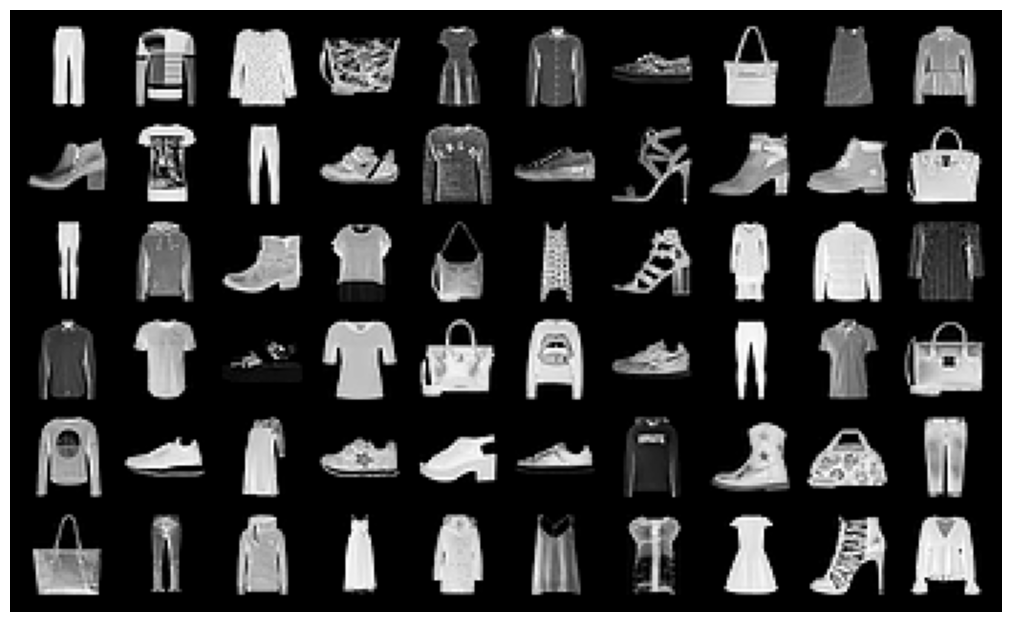

In [6]:
images_columns = 10
images_rows    = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)


## Implement a VAE neural network architecture

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, σ²)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance.

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

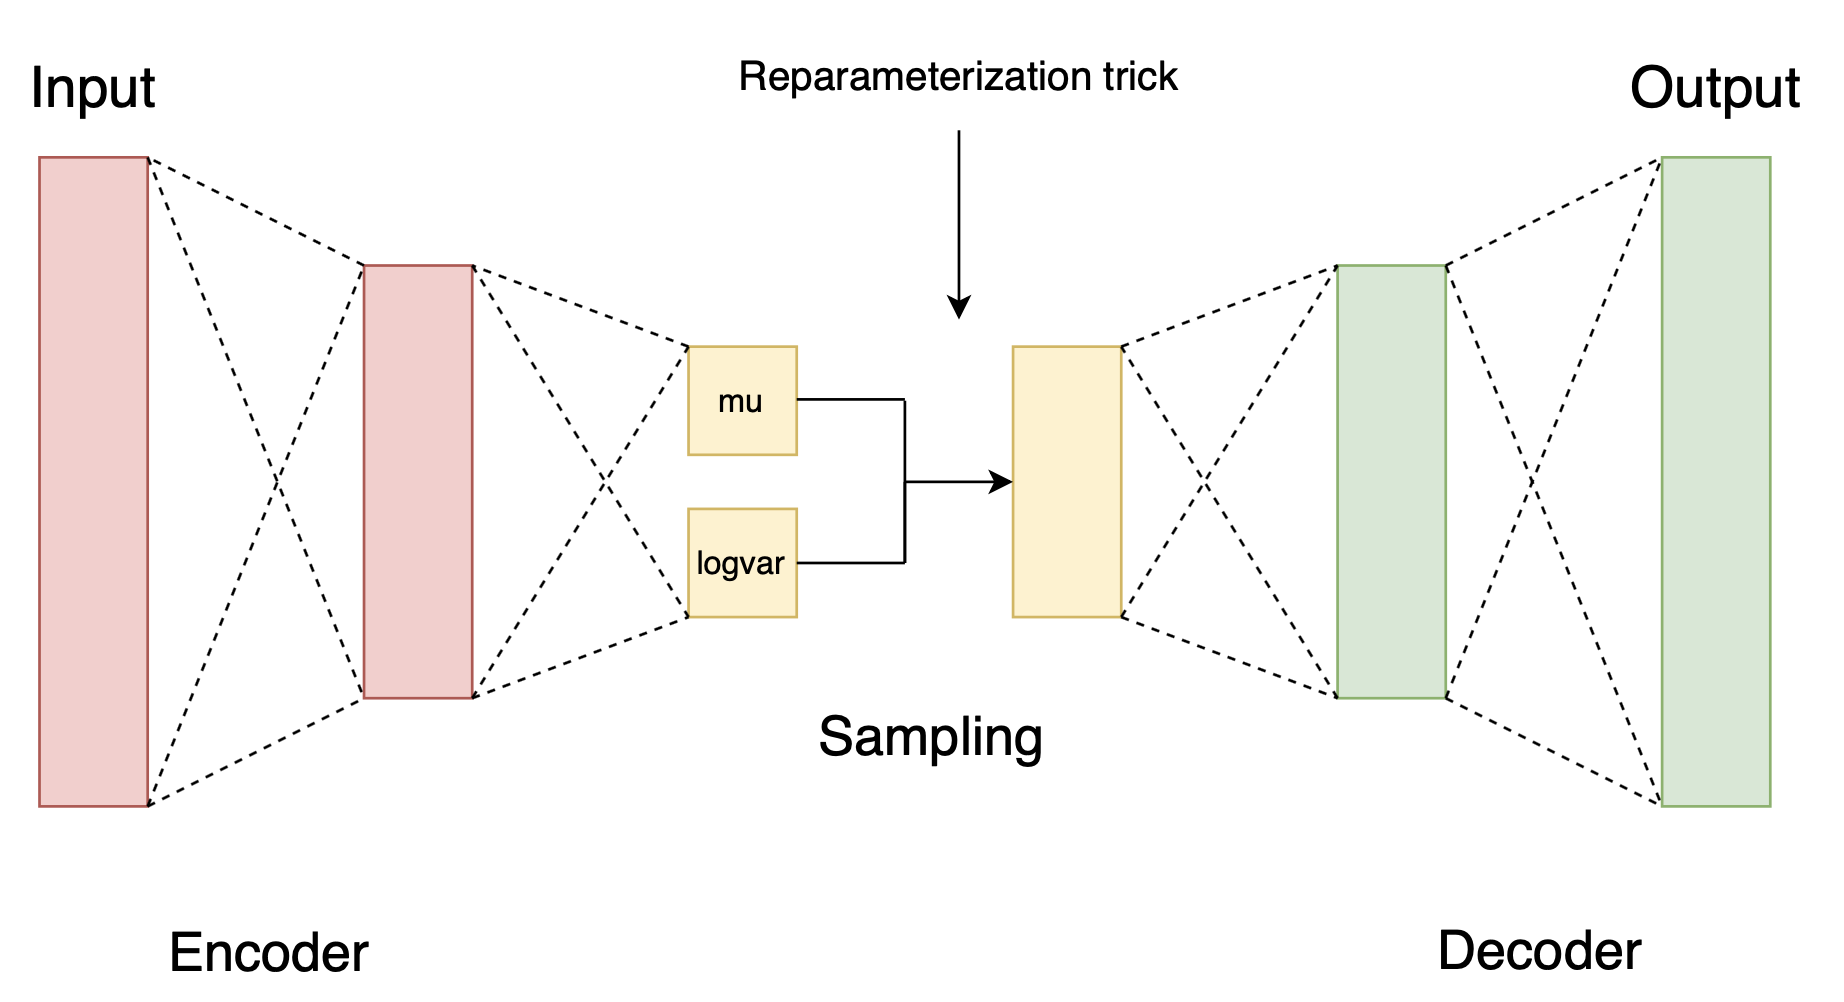

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly:

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer

**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the trick do and why do we need it?

**ANSWER**
The reparameterization trick is a powerful method that makes the training of VAEs possible and efficient. By cleverly separating the random and deterministic elements of the sampling operation in the VAE, it allows us to leverage the power of backpropagation while maintaining the stochastic nature of the model.

In [7]:
# TODO Implement the VAE
class VAE(nn.Module):
    def __init__(self, in_channels=1, capacity=capacity, latent_dims=latent_space_dim):
        super(VAE, self).__init__()
        self.latent_dims=latent_dims
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(capacity, 2 * capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Sampling
        self.fc_mu = nn.Linear(2 * capacity * 7 * 7, latent_dims)
        self.fc_logvar = nn.Linear(2 * capacity * 7 * 7, latent_dims)
        self.z = nn.Linear(latent_dims, 2 * capacity * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2 * capacity, capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(capacity, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        z = self.z(z)
        z = z.view(z.size(0), 2 * capacity, 7, 7)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [26]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, capacity=32):
        super(Encoder, self).__init__()
        self.cov2d_1 = nn.Conv2d(in_channels=in_channels, out_channels=capacity,
                                 kernel_size=4, padding=1, stride=2)
        self.relu1 = nn.ReLU()
        self.cov2d_2 = nn.Conv2d(in_channels=capacity, out_channels=2*capacity,
                                 kernel_size=4, padding=1, stride=2)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.cov2d_1(x)
        x = self.relu1(x)
        x = self.cov2d_2(x)
        x = self.relu2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels=1, capacity=32):
        super(Decoder, self).__init__()
        self.cov2d_1 = nn.ConvTranspose2d(in_channels=2*capacity, out_channels=capacity,
                                 kernel_size=4, padding=1, stride=2)
        self.relu1 = nn.ReLU(True)
        self.cov2d_2 = nn.ConvTranspose2d(in_channels=capacity, out_channels=out_channels,
                                 kernel_size=4, padding=1, stride=2)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.cov2d_1(x)
        x = self.relu1(x)
        x = self.cov2d_2(x)
        x= self.sig(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, capacity, latent_dims):
        super(Autoencoder, self).__init__()
        self.latent_dims = latent_dims

        self.encoder = Encoder(capacity=capacity)

        self.mu = nn.Linear(2*capacity * 7 * 7, latent_dims)
        self.logvar = nn.Linear(2*capacity * 7 * 7, latent_dims)
        self.sampling = nn.Linear(latent_dims, 2*capacity * 7 * 7)

        self.decoder = Decoder(capacity=capacity)

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) #mu + eps*std


    def decode(self, x):
        x = self.sampling(x)
        x = x.view(-1, 2*capacity, 7, 7)
        x = self.decoder(x)
        return x

    def forward(self, x):
        image = x
        x = self.encoder(x).view(x.size(0), -1)

        mu = self.mu(x)
        logvar = self.logvar(x)
        sample = self.reparameterize(mu, logvar)

        x = self.sampling(sample)
        x = x.view(-1, 2*capacity, 7, 7)
        x = self.decoder(x)

        return x , mu, logvar

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:**
- Make sure that you use sum instead of mean for calculating the MSE loss!
- Refer to the paper _Auto-Encoding Variational Bayes_ by Kingma and Welling to implement the loss function.

In [8]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and
    # summed over all elements and batch
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')
    #mse_loss =  ((recon_x - x)**2).sum()

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta

    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [9]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot**


In [11]:
def run_train_test(autoencoder, train_data, test_data, optimizer, device, epochs):
    loss_list, test_loss_list = [],[]
    for epoch in range(epochs):
        loss_tot = train_evaluate(autoencoder, train_data, optimizer, device)
        loss_list.append(loss_tot)
        loss_test = test_evaluate(autoencoder, test_loader, device)
        test_loss_list.append(loss_test)
        print("Epoch=", epoch, " train loss: ", loss_tot , " test loss:", loss_test)
    return loss_list, test_loss_list

def train_evaluate(autoencoder, train_data, optimizer, device):
    model.train()
    loss_tot = 0.0
    samples_cnt = 0.0
    for x, y in train_data:
        x, y = x.to(device), y.to(device) # GPU
        optimizer.zero_grad()
        x_hat, mu, logvar = autoencoder(x)
        total_loss, _, _ = vae_loss(x_hat, x, mu, logvar)
        total_loss.backward()
        loss_tot += total_loss.item()
        samples_cnt += x.size(0)
        optimizer.step()

    return loss_tot/samples_cnt

def test_evaluate(autoencoder,  test_loader, device):
    losses = 0
    samples_cnt = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred_x_hat, mu, logvar = autoencoder(x)
            loss, _, _ = vae_loss(pred_x_hat, x, mu, logvar)
            losses += loss.item()
            samples_cnt += x.size(0)
    losses = losses / samples_cnt
    return losses


loss_train, loss_test = run_train_test(model, train_loader, test_loader,
                                      optimizer, device, epochs=epochs)

Epoch= 0  train loss:  35.5518150390625  test loss: 25.064219781494142
Epoch= 1  train loss:  27.731342427571615  test loss: 23.365615032958985
Epoch= 2  train loss:  26.855957572428384  test loss: 23.16064998779297
Epoch= 3  train loss:  26.36602714436849  test loss: 22.808171380615235
Epoch= 4  train loss:  26.025605419921874  test loss: 22.497202944946288


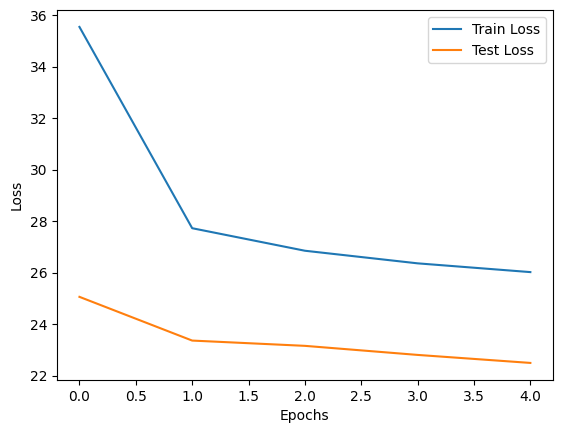

In [12]:
# TODO Plot the train and test set loss during training in the same plot!
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_test, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualization of random samples from the latent space via decoding

Here we just create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

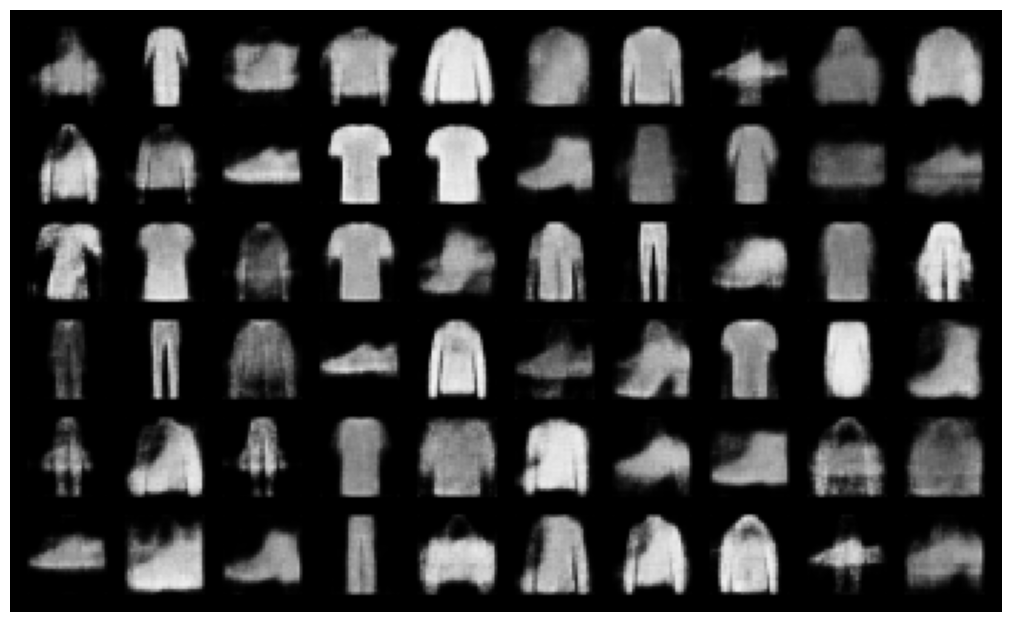

In [13]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_space_dim).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

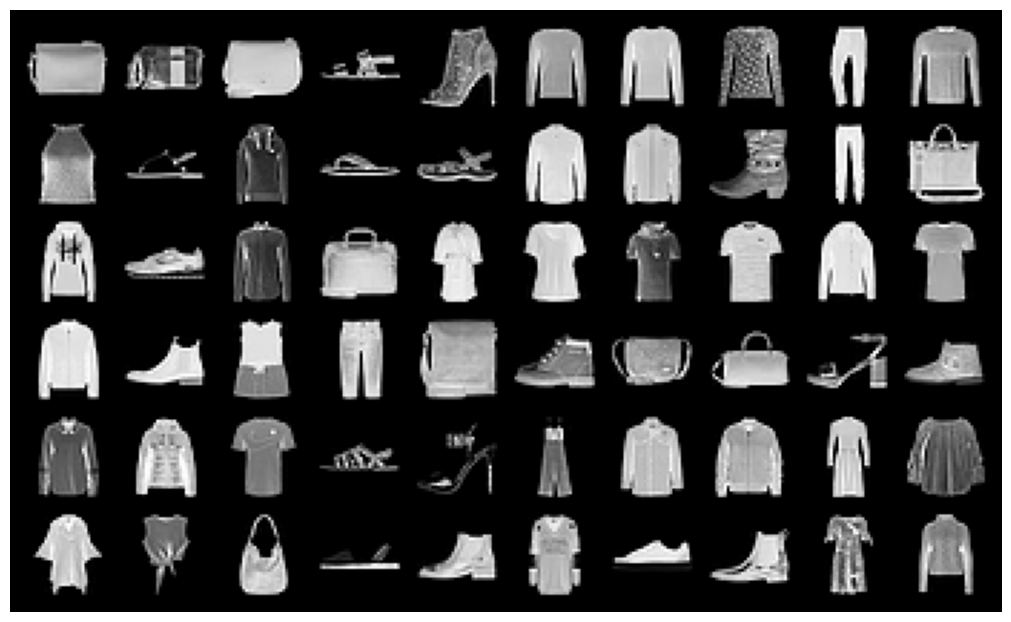

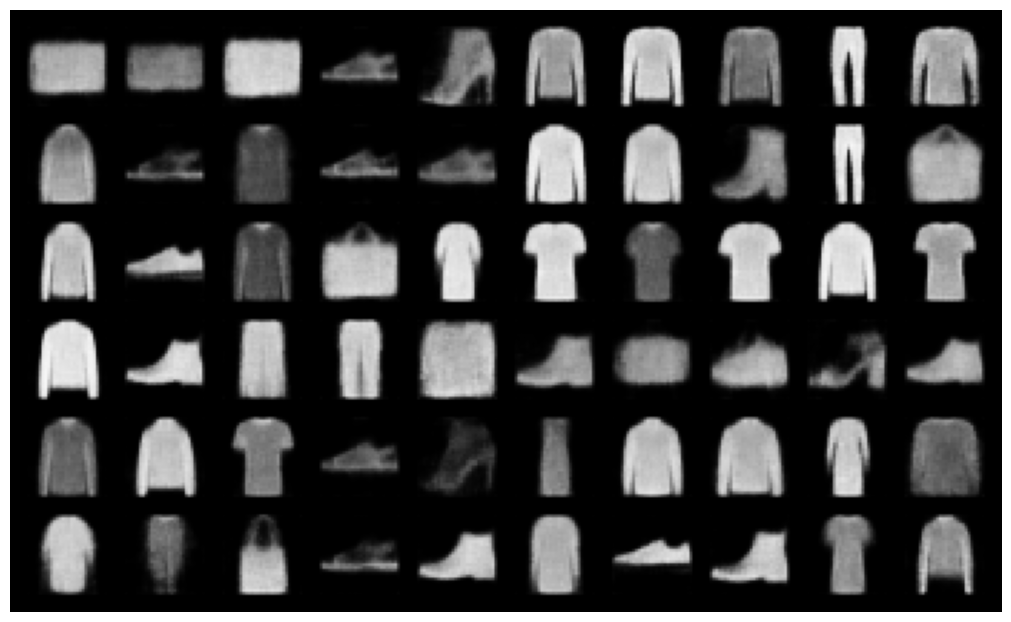

In [14]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,_,_ = model(images.to(device))
    images_recon=images_recon.to("cpu")
    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)

### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses.

latent dim:  2
Epoch= 0  train loss:  41.73759854329427  test loss: 32.01440364990234
Epoch= 1  train loss:  32.211557657877606  test loss: 30.539662643432617
Epoch= 2  train loss:  31.218885803222655  test loss: 29.777356378173828
Epoch= 3  train loss:  30.694352115885415  test loss: 29.5365923828125
Epoch= 4  train loss:  30.305486022949218  test loss: 29.148986242675782


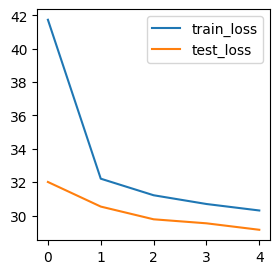

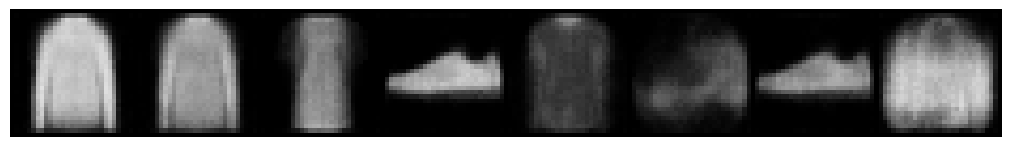

latent dim:  4
Epoch= 0  train loss:  37.45114801025391  test loss: 26.768921643066406
Epoch= 1  train loss:  27.684516133626303  test loss: 25.308176223754884
Epoch= 2  train loss:  26.7063160929362  test loss: 24.73019288635254
Epoch= 3  train loss:  26.223744124348958  test loss: 24.407840048217775
Epoch= 4  train loss:  25.948009908040365  test loss: 24.073831607055663


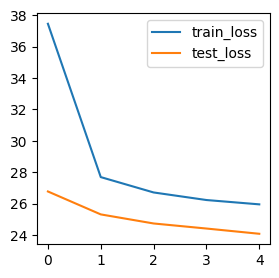

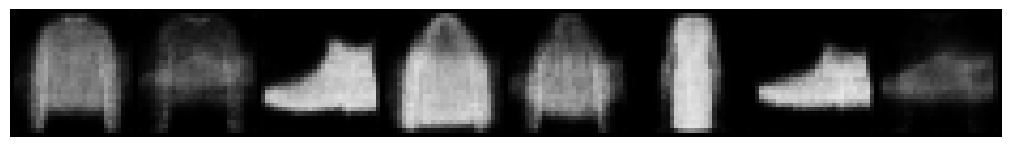

latent dim:  8
Epoch= 0  train loss:  38.208503564453125  test loss: 25.10003076171875
Epoch= 1  train loss:  27.596530716959634  test loss: 23.70000791015625
Epoch= 2  train loss:  26.64022860514323  test loss: 23.2312362701416
Epoch= 3  train loss:  26.134513338216145  test loss: 23.201925402832032
Epoch= 4  train loss:  25.784898311360678  test loss: 22.769544494628907


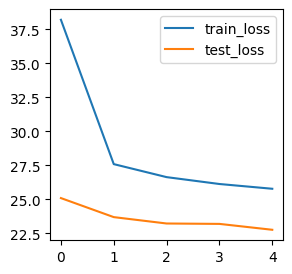

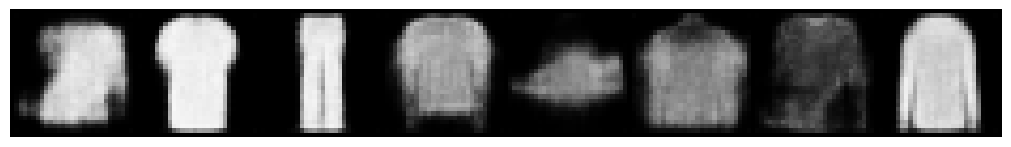

latent dim:  16
Epoch= 0  train loss:  37.47448310546875  test loss: 25.495543939208986
Epoch= 1  train loss:  28.303600659179686  test loss: 23.74670362548828
Epoch= 2  train loss:  27.086795947265625  test loss: 22.99487311706543
Epoch= 3  train loss:  26.503861083984376  test loss: 22.74136606140137
Epoch= 4  train loss:  26.14329617919922  test loss: 22.5063871887207


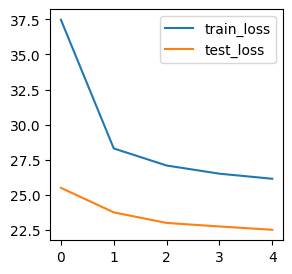

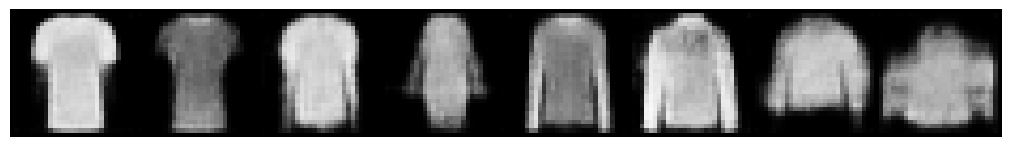

latent dim:  32
Epoch= 0  train loss:  41.29131156819661  test loss: 25.697740625
Epoch= 1  train loss:  28.60922813313802  test loss: 24.045443258666992
Epoch= 2  train loss:  27.44172822265625  test loss: 23.38932352294922
Epoch= 3  train loss:  26.828947733561197  test loss: 23.296234936523437
Epoch= 4  train loss:  26.416519213867186  test loss: 22.901884323120118


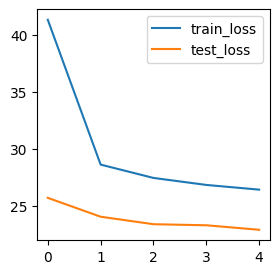

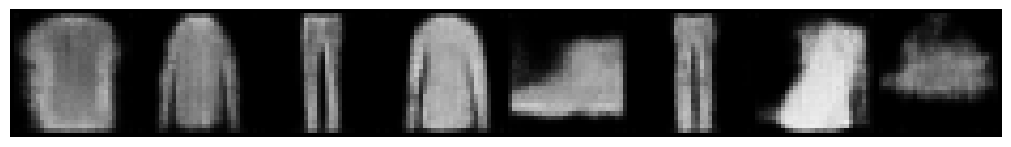

latent dim:  10
Epoch= 0  train loss:  37.773419108072915  test loss: 25.2549323638916
Epoch= 1  train loss:  27.87191190999349  test loss: 23.720107086181642
Epoch= 2  train loss:  26.830794307454426  test loss: 22.95326784057617
Epoch= 3  train loss:  26.259962923177085  test loss: 23.419726550292967
Epoch= 4  train loss:  25.923870288085936  test loss: 22.531435931396484


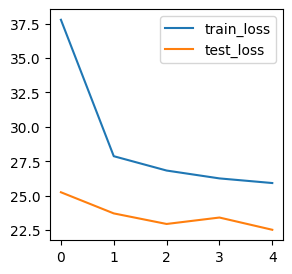

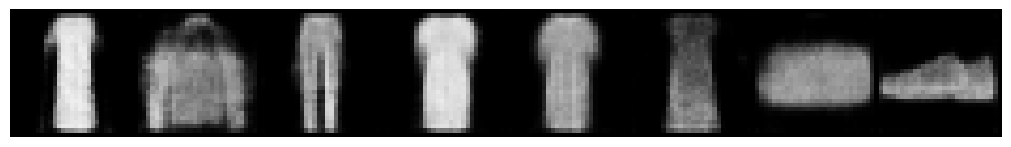

In [15]:
for lat_dims in [2,4,8,16,32,10]:
    print("latent dim: ", lat_dims)
    model = VAE( latent_dims=lat_dims).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate)

    loss_train, loss_test = run_train_test(model, train_loader, test_loader,
                                      optimizer, device, epochs=epochs)
    plt.figure(figsize=(3,3))
    plt.plot(loss_train, label='train_loss')
    plt.plot(loss_test,label='test_loss')
    plt.legend()
    plt.show()

    img_cols=8
    img_rows= 1
    with torch.no_grad():
        samples = torch.randn(img_cols * img_rows, lat_dims).to(device)
        samples = model.decode(samples).cpu()

        show_grid(samples[0:(img_cols * img_rows)], img_cols, img_rows)


## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code where we set

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

Here are two examples.

1x10 traversal of one latent dimension

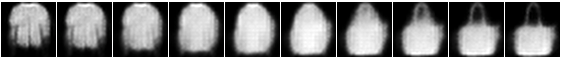

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

torch.Size([10, 10])


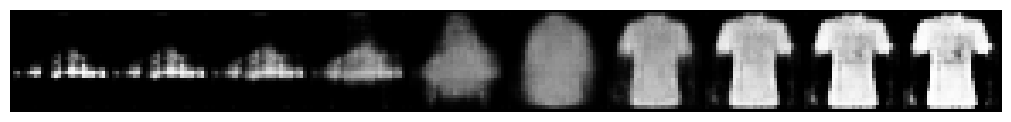

In [16]:
n=10
xs = [-3 + i*6/(n*latent_space_dim) for i in range(n*latent_space_dim)]

coords = torch.tensor(xs).reshape(n, latent_space_dim).to(device)
print(coords.shape)

nrows, ncols = 1, n

with torch.no_grad():
    samples = model.decode(coords).cpu()
    show_grid(samples[0:(ncols * nrows)], ncols, nrows)

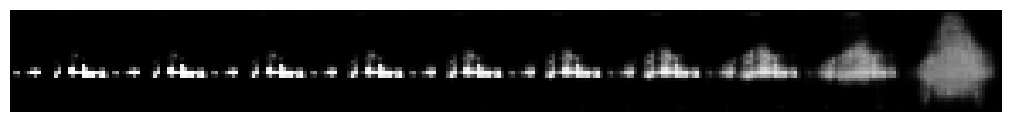

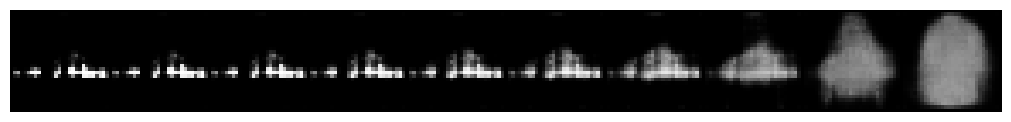

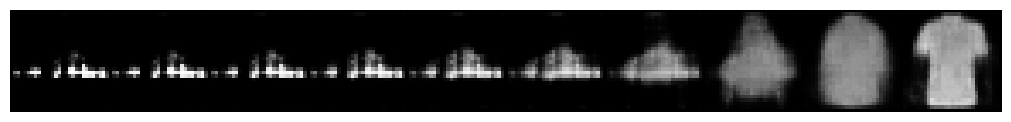

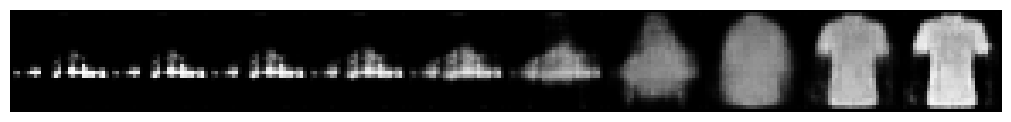

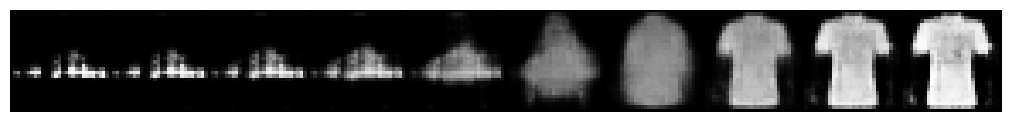

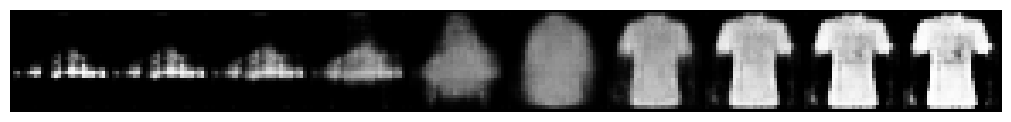

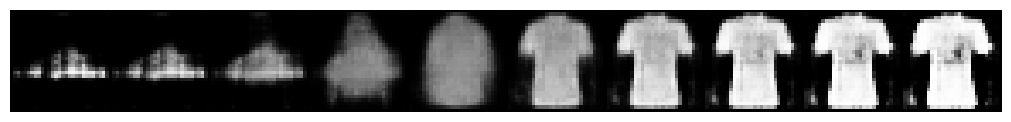

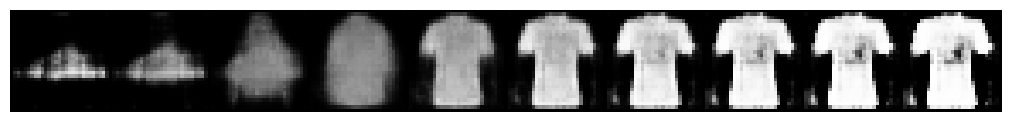

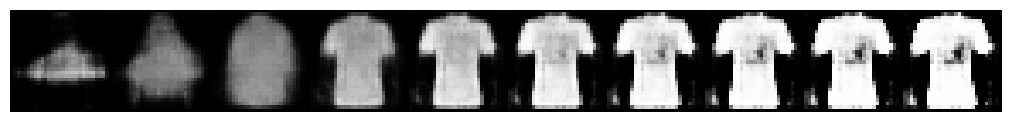

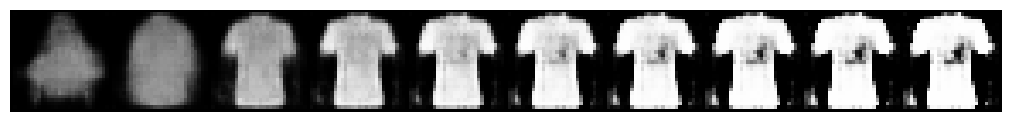

In [17]:
n=10
m=10

ys = [-3 + i*6/(m) for i in range(m)]
for y in ys:
    xs = [-3+y + i*(6)/(n*latent_space_dim) for i in range(n*latent_space_dim)]

    coords = torch.tensor(xs).reshape(n, latent_space_dim).to(device)

    nrows, ncols = 1, n

    with torch.no_grad():
        samples = model.decode(coords).cpu()
        show_grid(samples[0:(ncols * nrows)], ncols, nrows)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels.

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

**Answer **
1. datapoints with similar lables are close to each other and usally form clusters. We observe overlaps between clusters of data which we have also realized after visualizing the latent traversals. For example, shirts and coats have strong overlap which was not unexpected.

2. the different classes in the latent space look normaldistributed besides a few data points, which deviate fron this distribution.

#### Train 2d latent space model

Epoch= 0  train loss:  41.18026123860677  test loss: 32.88785364990235
Epoch= 1  train loss:  32.32417693684896  test loss: 31.654366857910155
Epoch= 2  train loss:  31.442633622233075  test loss: 31.06050782470703
Epoch= 3  train loss:  30.930994128417968  test loss: 30.786786138916014
Epoch= 4  train loss:  30.614548388671874  test loss: 30.352077545166015


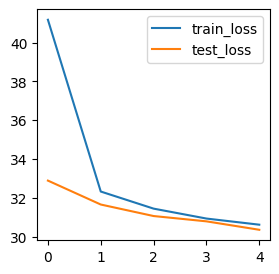

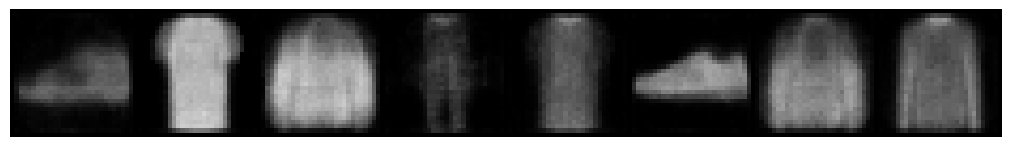

In [36]:
lat_dims = 2
model = Autoencoder(capacity=capacity, latent_dims=lat_dims).to(device)# TODO
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=learning_rate)

loss_train, loss_test = run_train_test(model, train_loader, test_loader,
                                  optimizer, device, epochs=epochs)
plt.figure(figsize=(3,3))
plt.plot(loss_train, label='train_loss')
plt.plot(loss_test,label='test_loss')
plt.legend()
plt.show()

img_cols=8
img_rows= 1
with torch.no_grad():
    samples = torch.randn(img_cols * img_rows, lat_dims).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(img_cols * img_rows)], img_cols, img_rows)

#### Visualize classes

In [40]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

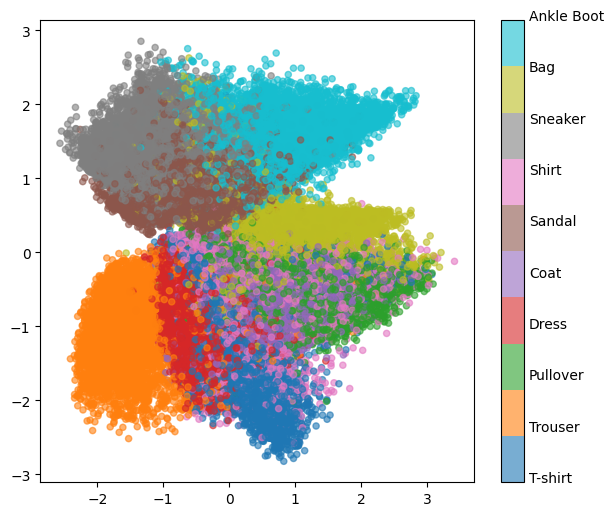

In [41]:
plt.figure(figsize=(7, 6))
list_mu, list_labels = [], []
with torch.no_grad():
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        pred_x_hat, mu, logvar = model(img)

        list_mu.append(mu.cpu())
        list_labels.append(label.cpu())

mus = torch.cat(list_mu, dim=0)
labels = torch.cat(list_labels, dim=0)


scatter = plt.scatter(mus[:,0], mus[:,1], c=labels, cmap='tab10', alpha=0.6, s=20)
cbar = plt.colorbar()

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(list(labels_map.values())):
    cbar.ax.text(1.2, j, lab)
cbar.ax.get_yaxis().labelpad = 5

plt.show()

0


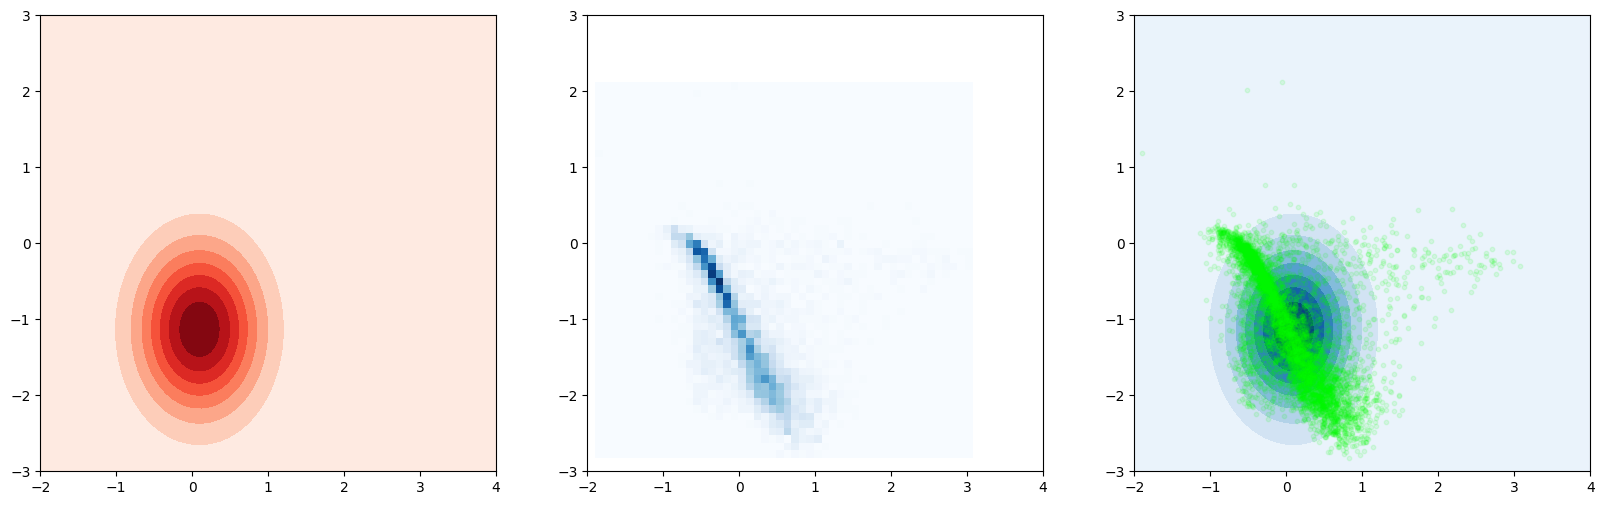

1


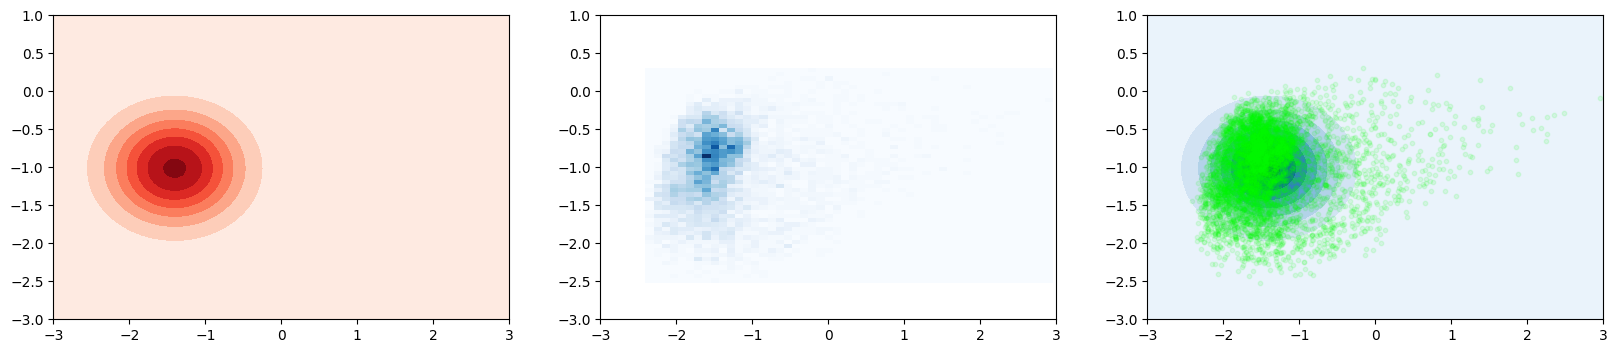

2


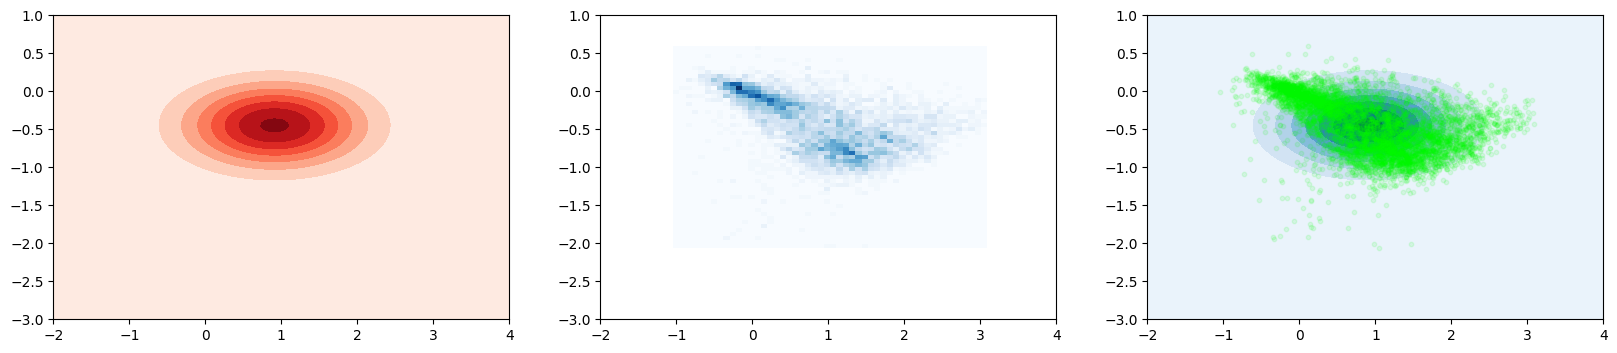

3


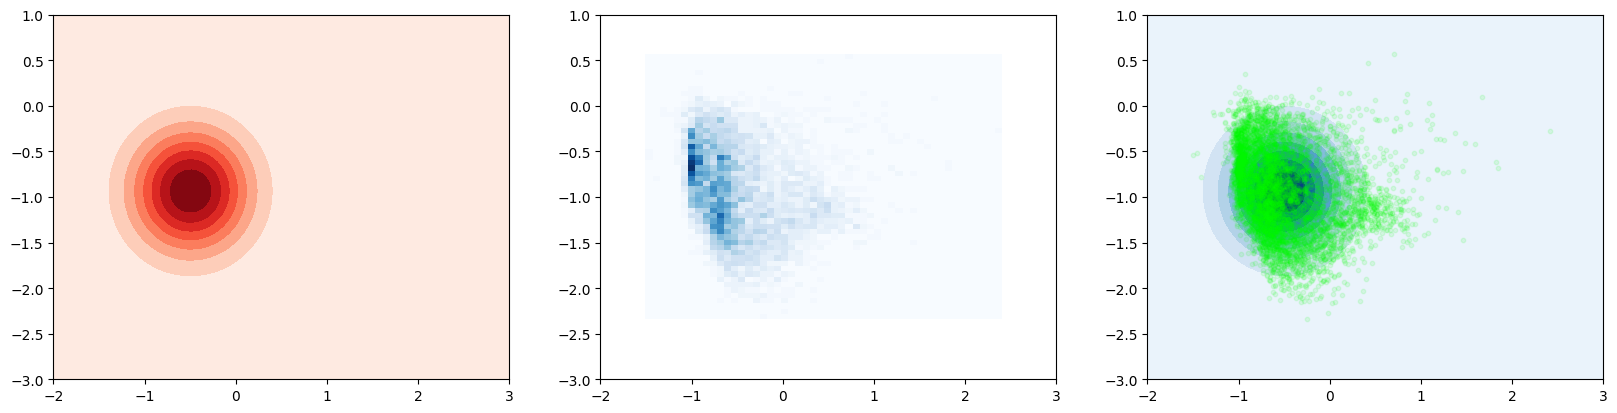

4


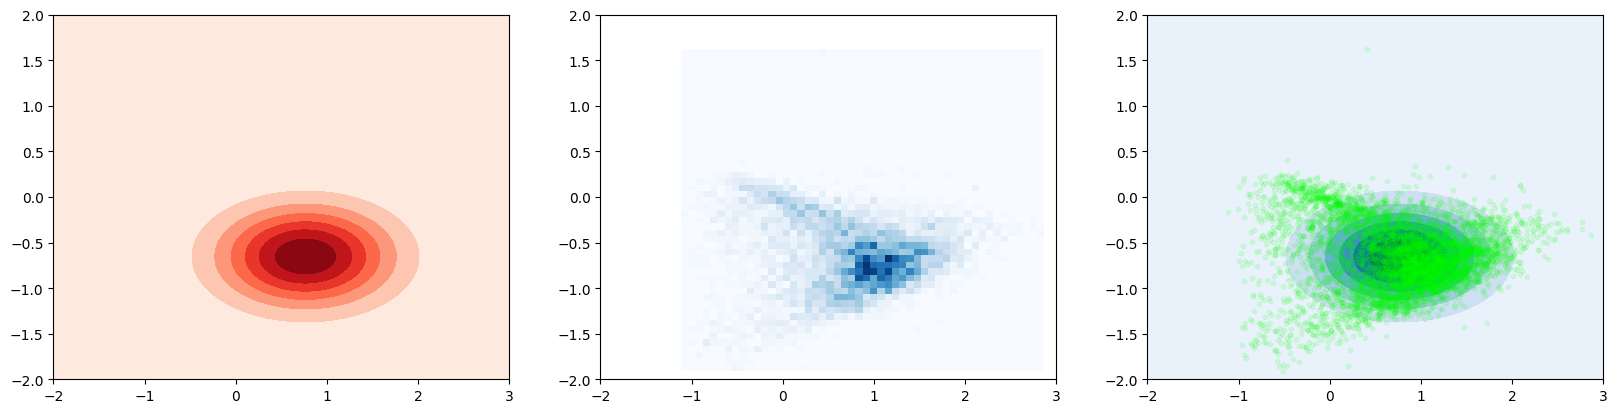

5


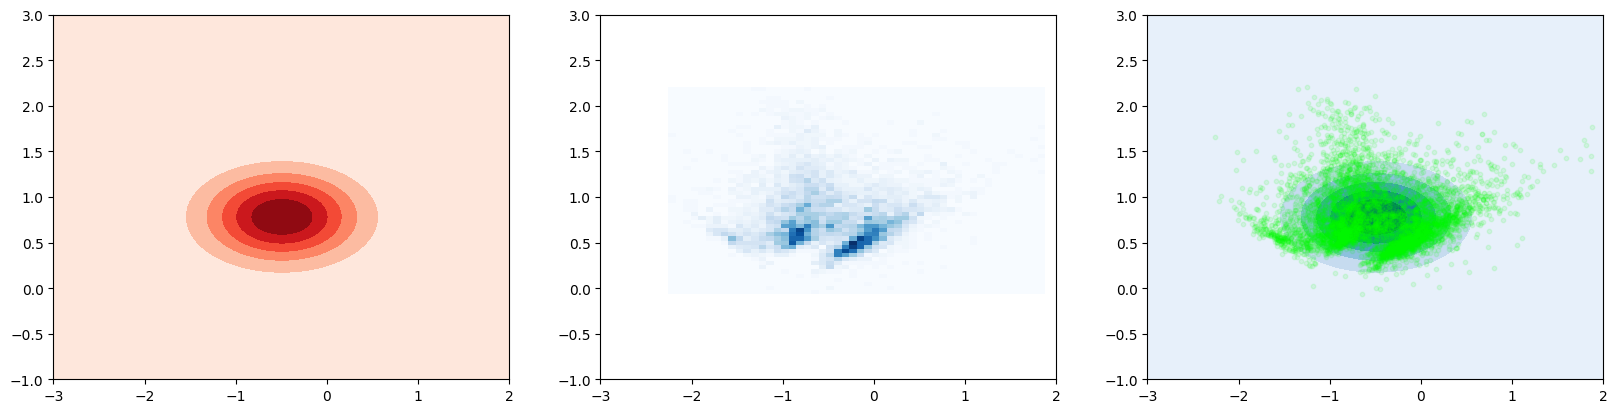

6


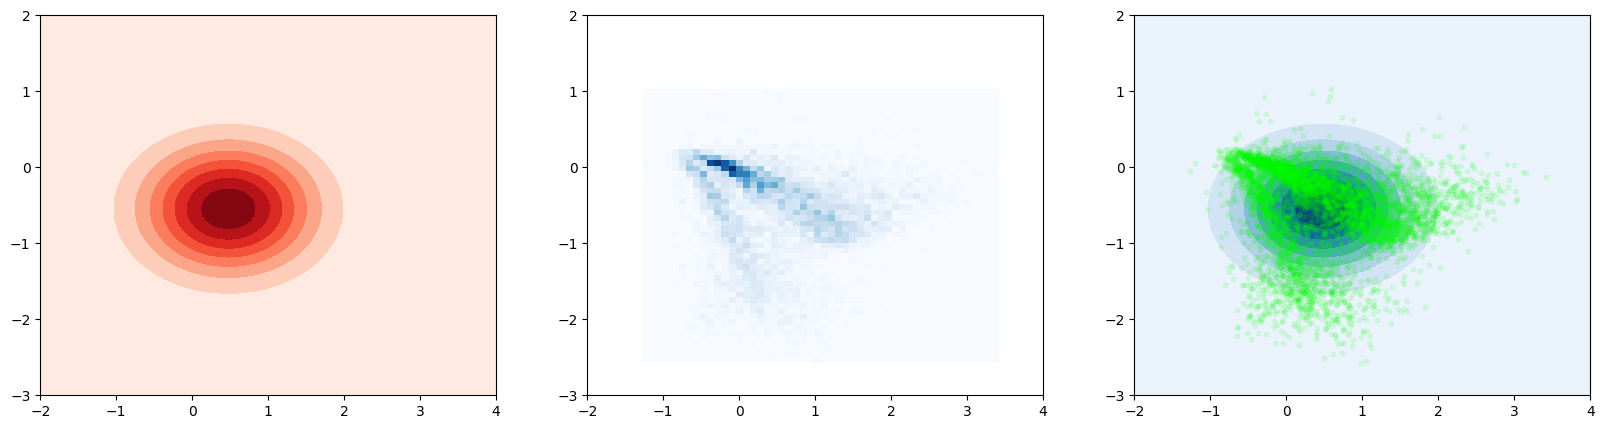

7


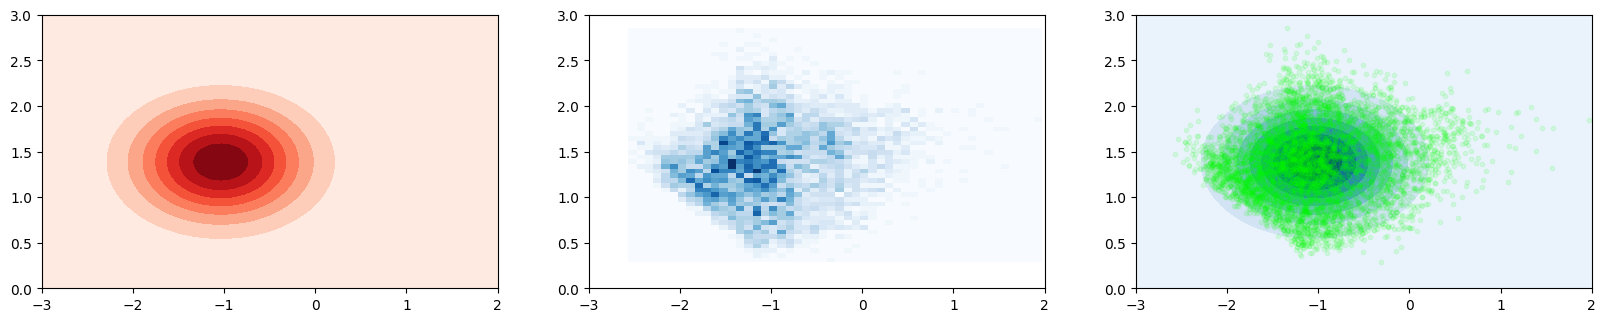

8


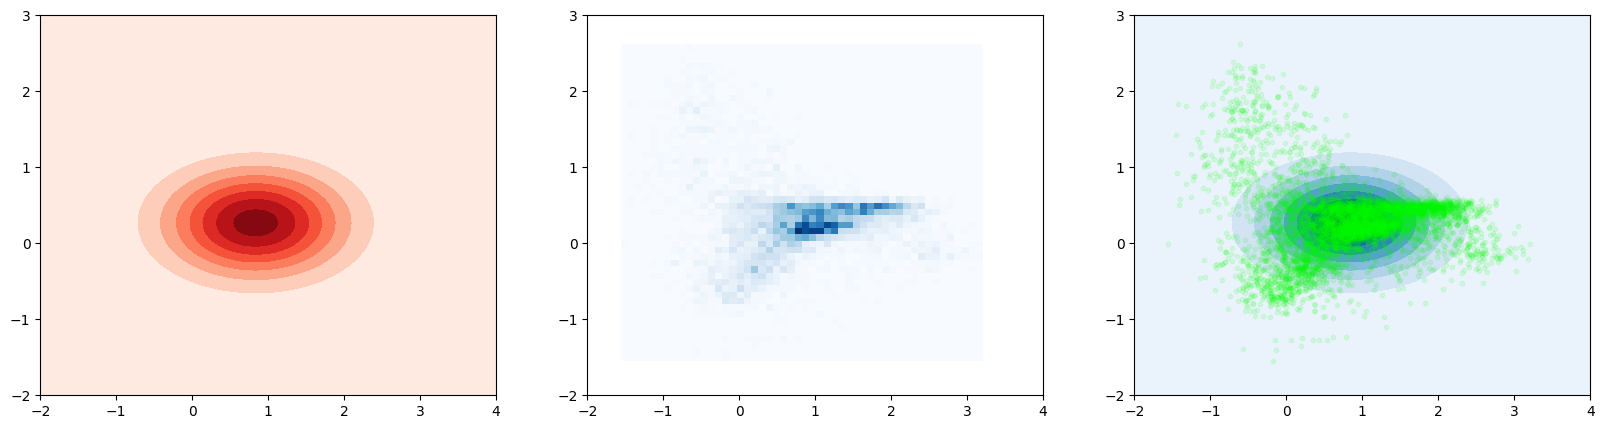

9


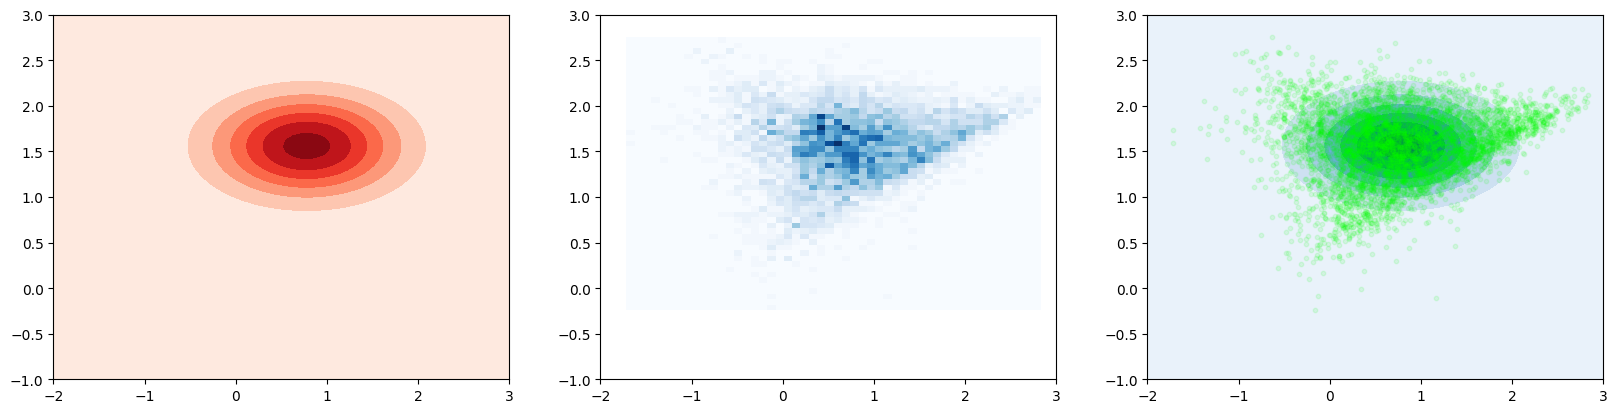

In [42]:
for z in range(10):
  fig,ax=plt.subplots(1,3,figsize=(20,10))
  print(z)
  one=[]
  c=0


  for i,l in enumerate(labels):
    if l==z:
      c+=1
      one.append(mus[i,:].numpy())
  one=np.array(one)
  size = 100
  minx=int(one[:,0].min()-1)
  maxx=int(one[:,0].max()+1)
  miny=int(one[:,1].min()-1)
  maxy=int(one[:,1].max()+1)
  mean=one.mean(axis=0)
  std=one.std(axis=0)
  #normal=np
  sigma_x =std[0]
  sigma_y =std[1]

  x = np.linspace(minx, maxx, size)
  y = np.linspace(miny, maxy, size)

  x, y = np.meshgrid(x, y)
  z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-((x-mean[0])**2/(2*sigma_x**2)
      + (y-mean[1])**2/(2*sigma_y**2))))


  ax[2].contourf(x, y, z, cmap='Blues')
  #ax[2].colorbar()
  ax[2].scatter(one[:,0], one[:,1],alpha=0.1, s=10,c="lime")
  ax[2].set_xlim(minx, maxx)
  ax[2].set_ylim(miny, maxy)
  ax[2].set_aspect('equal', adjustable='box')

  ax[0].contourf(x, y, z, cmap='Reds',alpha=1)
  ax[0].set_xlim(minx, maxx)
  ax[0].set_ylim(miny, maxy)
  ax[0].set_aspect('equal', adjustable='box')


  #ax[0].colorbar()
  #plt.show()
  # Create a 2D histogram

  ax[1].hist2d(one[:, 0], one[:, 1], bins=(50, 50), cmap=plt.cm.Blues,alpha=1)
  ax[1].set_xlim(minx, maxx)
  ax[1].set_ylim(miny, maxy)
  ax[1].set_aspect('equal', adjustable='box')

  plt.show()


# Appendix [OPTIONAL]


Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [ ]:
transform = transforms.Compose([
               transforms.Resize(image_size),
                transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())